# Implementing random-walk Metropolis-Hastings

In [1]:
# Here are a couple of models that you will probably need 
import numpy as np 
import random
import matplotlib.pyplot as plt 
from scipy.integrate import simps
from scipy.optimize import least_squares
import functools
from scipy import linalg


In [2]:
# First, we need to define the model as a function of its parameters w and input variables x
def increasing_sinus_model(x, w):
    y = w[0]*np.sin(w[1]*x*(np.pi/2)) + w[1]*x 
    
    return y 


## Generate synthetic data 
We need data to perform the inference. We generate synthetic data using the probabilistic model.


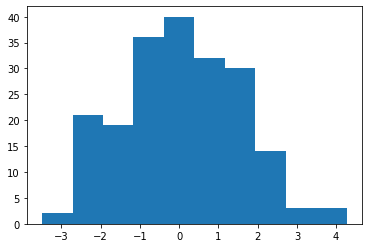

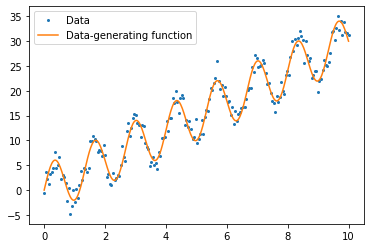

In [3]:
# We need to fix parameter values to generate the data
w0 = 5.; w1 = 3.
dim = 2 # Dimension of the problem 

# data x-field 
nx_data = 200
x_data = np.linspace(0,10,nx_data) 

# Generate Gaussian perturbations with standard deviation sigma_y 
sigma_y = 1.5
rn = [(random.gauss(0,sigma_y)) for i in range(nx_data)]

# You could check that your data looks normal by checking the histogram  
plt.figure(0)
plt.hist(rn)

# Generate the baseline solution of the model at x_data
y_nom = increasing_sinus_model(x_data, [w0, w1])

# Perturb the data 
y_noisy = y_nom + rn

#Plot the data and the data generating functon 
# For vizualisation, x-field for the model can be more refined
nx_model = 400
x_model = np.linspace(0,10,nx_model) 
y_nom = increasing_sinus_model(x_model, [w0, w1])

# Plot data
plt.figure(1)
plt.plot(x_data, y_noisy, 'o', markersize=2, label="Data")
plt.plot(x_model, y_nom, label="Data-generating function")
plt.legend()
plt.show()

Value of the MLE = [4.9224245  2.99561427]


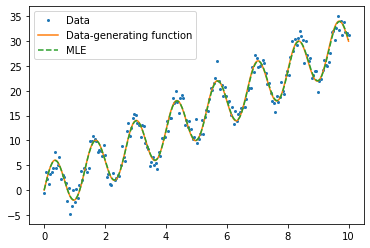

In [4]:
# Find the MLE by solving the least-square problem. You can use your 
# favorite optimization algorithm. Here, we use the Levenberg-Marquardt 
# algorithm as implemented in MINPACK. Doesn’t handle bounds and sparse Jacobians. 
# Usually the most efficient method for small unconstrained problems.
lsq_fun = lambda w: (increasing_sinus_model(x_data,w)-y_noisy)
res = least_squares(lsq_fun, [w0, w1], method="lm")
w_MLE = res.x
print("Value of the MLE = {}".format(w_MLE))


# x-field for the model can have a more refine discretization for plotting the result 
nx_model = 400
x_model = np.linspace(0,10,nx_model) 

# The MLE will be closed to the data generating function, but it varies every time new random data are generated
y_MLE = increasing_sinus_model(x_model, res.x) 

# Plot data 
plt.figure(2)
plt.plot(x_data, y_noisy, 'o', markersize=2, label="Data")
plt.plot(x_model, y_nom, label="Data-generating function")
plt.plot(x_model, y_MLE, '--', markersize=2, label="MLE")
plt.legend()
plt.show()

## Bayesian Parameter inference
Now that we have the data, we can build the posterior from Bayes' formula 

In [5]:
# Define likelihood function.
# We will use the gaussian pdf (check lecture 6) 
def fun_LL(w):
    return np.exp(-1/2/sigma_y**2*np.sum((y_noisy - increasing_sinus_model(x_data, w))**2))
    
# Prior function is uniform and is just a constant 


# Note: because the problem is 2D, we can easily compute the posterior by screening the values of the parameters 
n_point_screening = 400
vec_param_i = np.linspace(3.5, 6.5, n_point_screening)
vec_param_j = np.linspace(2.9, 3.10, n_point_screening)

f_post = np.zeros([vec_param_i.size, vec_param_j.size])
for i, param_i in np.ndenumerate(vec_param_i): 
    for j, param_j in np.ndenumerate(vec_param_j): 
        c_param = np.array([param_i, param_j])
        f_post[i,j] = fun_LL(c_param) 
        
# The posterior needs to be normalized. Integration can be performed in both directions     
f_post_w0 = simps(f_post, vec_param_j) # Integrate over f_w1
f_post_w1 = simps(f_post, vec_param_i) #Integrate over f_w0
norm_f_post = simps(f_post_w0, vec_param_i) # Integrate over f_w0
norm_f_post_2 = simps(f_post_w1, vec_param_j) # Integrate over f_w1
print(norm_f_post, norm_f_post_2) # They should be the same 
f_post /= norm_f_post_2 # or norm_f_post_2
        


3.081801116281202e-44 3.08180111628122e-44


(2.99, 3.01)

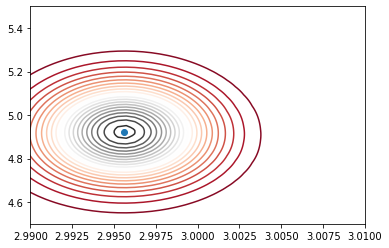

In [6]:
plt.figure(3)
plt.contour(vec_param_j, vec_param_i, f_post, 25, cmap='RdGy')
# We can also plot on the graph the MLE ! 
plt.plot(w_MLE[1], w_MLE[0], 'o')
plt.ylim([4.5, 5.5]) # xlim and ylim might need adjustement 
plt.xlim([2.99, 3.01])

## Metropolis-Hastings algorithm
We could obtain the posterior distribution by screening the parameter values. However, here we want to sample from it. So let's build the MCMC algorithm, in particular the random-walk Metropolis-Hastings.  

In [16]:
#MCMC method parameter 
n_it = int(1e4)
proposal_cov = np.array([[0.05,0.], [0.,0.0001]])
w_n = np.zeros((n_it+1, dim)) # np array to store the sample values

# Initialise 
R = linalg.cholesky(proposal_cov)
w_n[0,:] = w_MLE

# MCMC lopp 
for n in range(n_it): 

    # 1. Sample from the multivariate Gaussian 
    # First, we generate the normal centering gaussian 
    mv_norm = np.zeros(dim)
    for j in range(dim):
        mv_norm[j] = random.gauss(0, 1)  

    w_star = w_n[n, :] + np.transpose(np.matmul(R, np.transpose(mv_norm)))

    # 2. Compute posterior value at the proposed sample 
    r = fun_LL(w_star)/fun_LL(w_n[n,:])
    
    # 3. Compute acceptance probability 
    alpha = min(1, r)
    
    # 4. Accept-reject
    if random.random() < alpha:  # Accepted
        w_n[n+1,:] = w_star
    else:  # Rejected, current val remains the same
        w_n[n+1,:] = w_n[n,:]



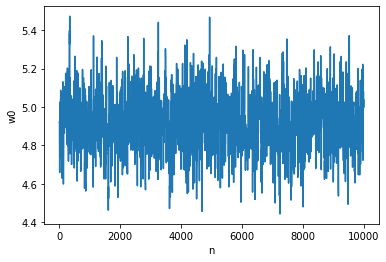

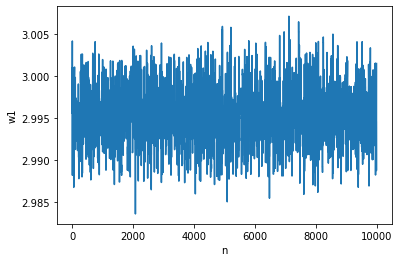

In [17]:
      
plt.figure()
plt.plot(w_n[:, 0])
plt.ylabel("w0")
plt.xlabel("n")

plt.figure()
plt.plot(w_n[:, 1])
plt.ylabel("w1")
plt.xlabel("n")

plt.show()
